In [1]:
#!/usr/bin/python3

from ReadStats import Statistics, Pdfs 
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style
from matplotlib import rc

rc('text', usetex=True)
rc('text.latex', preamble=r"\usepackage{fourier}")
rc('font', family='serif')
rc('font', size=24)
rc('axes', linewidth=1.5)
rc('axes', labelsize=24)
rc('lines', linewidth=2)

opath = '/Volumes/Seagate/SCRATCH/plots/3D/Re025/Rapids/'

path_S0    = '/Volumes/Seagate/SCRATCH/qCBL_3D/Re025/2560x512x2560/'
path_S05   = '/Volumes/Seagate/SCRATCH/qCBL_3D/Re025/1280x512x1280-S05/'
path_S10   = '/Volumes/Seagate/SCRATCH/qCBL_3D/Re025/1280x512x1280-S10/'
path_S15   = '/Volumes/Seagate/SCRATCH/qCBL_3D/Re025/1536x576x1536-S15/'
path_S20_1 = '/Volumes/Seagate/SCRATCH/qCBL_3D/Re025/S20-1536x576x1536/'
path_S20_2 = '/Volumes/Seagate/SCRATCH/qCBL_3D/Re025/S20-1536x576x2304/'
path_S25   = '/Volumes/Seagate/SCRATCH/qCBL_3D/Re025/2560x896x2560-S25/'

In [2]:
# Constants

nu = 1./15000.
B0 = 0.005
N = np.sqrt(3)
L0 = (B0/N**3)**0.5
ceps = 0.1

In [3]:
def runningmean(timeseries,window):
    """
    Calculate a running mean of a time series with a specified window size.
    Window size is number of entries on either side of the entry being averaged.
    Leaves out entries at the beginning and end of the time series such that the
    window size is always the same, but the resulting time series is shorter than
    the original.
    """
    
    nt = len(timeseries)
    outseries = np.zeros(nt-(window*2))
    for n in range(window,nt-window):
        outseries[n-window] = np.mean(timeseries[n-window:n+window+1])
    return outseries

def find_nearest_bisection(array,value):
    """
    Returns an index j such that ``value`` is between array[j]
    and array[j+1]. ``array`` must be monotonic increasing. j=-1 or j=len(array) is returned
    to indicate that ``value`` is out of range below and above respectively.
    """

    n = len(array)
    if (value < array[0]):
        return -1
    elif (value > array[n-1]):
        return n
    jl = 0                      # Initialize lower
    ju = n-1                    # and upper limits.
    while (ju-jl > 1):          # If we are not yet done,
        jm=(ju+jl) >> 1         # compute a midpoint with a bitshift
        if (value >= array[jm]):
            jl=jm               # and replace either the lower limit
        else:
            ju=jm               # or the upper limit, as appropriate.
                                # Repeat until the test condition is satisfied.
    if (value == array[0]):     # edge cases at bottom
        return 0
    elif (value == array[n-1]): # and top
        return n-1
    else:
        return jl

def running_average(x,f,dx,m):
    """
    Calculate running average over dx at equally spaced m points.
    Assuming the independent variable x is non-decreasing.
    """

    # Defining the final independent variable
    yl = x[0]  +0.5 *dx
    yr = x[-1] -0.5 *dx
    y = np.linspace(yl,yr,m)

    avg = np.empty(m)
    std = np.empty(m)

    for j in range(m):
        yl = y[j] -0.5 *dx
        jl = find_nearest_bisection(x,yl) +1
        yr = y[j] +0.5 *dx
        jr = find_nearest_bisection(x,yr)

        # avg[j] = np.trapz(  f[jl:jr+1]            ,x[jl:jr+1]) /( x[jr]-x[jl] )
        if jl > 0:
            al = ( x[jl] -yl )/( x[jl] -x[jl-1] )
            al = 0.5 *( x[jl] -yl ) *( al *f[jl-1] +(2.0-al)*f[jl] )
        else:
            al = 0.0

        if jr < np.size(x)-1:
            ar = ( yr -x[jr] )/( x[jr+1] -x[jr] )
            ar = 0.5 *( yr -x[jr] ) *( ar *f[jr+1] +(2.0-ar)*f[jr] )
        else:
            ar = 0.0

        avg[j] = ( np.trapz(  f[jl:jr+1]            ,x[jl:jr+1]) +al +ar )/dx

    return y, avg

In [4]:
S0    = Statistics(path_S0+'stats/pdftimes/avg10000-54000.nc')
S05   = Statistics(path_S05+'stats/pdftimes/avg12000-67000.nc')
S10   = Statistics(path_S10+'stats/pdftimes/avg13000-84000.nc')
S15   = Statistics(path_S15+'stats/pdftimes/avg15000-92000.nc')
S20_1 = Statistics(path_S20_1+'stats/pdftimes/avg17000-35000.nc')
S20_2 = Statistics(path_S20_2+'stats/pdftimes/avg39000-91000.nc')
S25   = Statistics(path_S25+'stats/pdftimes/avg28000-128000.nc')

z_enc_S20 = np.concatenate((S20_1.z_enc,S20_2.z_enc))
z_enc_arg_S20 = np.concatenate((S20_1.z_enc_arg,S20_2.z_enc_arg))

z_enc_runningmean_S0 = runningmean(S0.z_enc,1)
z_enc_runningmean_S05 = runningmean(S05.z_enc,1)
z_enc_runningmean_S10 = runningmean(S10.z_enc,1)
z_enc_runningmean_S15 = runningmean(S15.z_enc,1)
z_enc_runningmean_S20 = runningmean(z_enc_S20,1)
z_enc_runningmean_S25 = runningmean(S25.z_enc,1)

In [5]:
# Pdf

vortlist_S0 = [path_S0+'stats/pdfs/pdf10000.LnEnstrophyW_iW_i',path_S0+'stats/pdfs/pdf11000.LnEnstrophyW_iW_i',path_S0+'stats/pdfs/pdf13000.LnEnstrophyW_iW_i',path_S0+'stats/pdfs/pdf15000.LnEnstrophyW_iW_i',path_S0+'stats/pdfs/pdf17000.LnEnstrophyW_iW_i',path_S0+'stats/pdfs/pdf19000.LnEnstrophyW_iW_i',path_S0+'stats/pdfs/pdf21000.LnEnstrophyW_iW_i',path_S0+'stats/pdfs/pdf24000.LnEnstrophyW_iW_i',path_S0+'stats/pdfs/pdf27000.LnEnstrophyW_iW_i',path_S0+'stats/pdfs/pdf30000.LnEnstrophyW_iW_i',path_S0+'stats/pdfs/pdf32500.LnEnstrophyW_iW_i',path_S0+'stats/pdfs/pdf36500.LnEnstrophyW_iW_i',path_S0+'stats/pdfs/pdf40500.LnEnstrophyW_iW_i',path_S0+'stats/pdfs/pdf45000.LnEnstrophyW_iW_i',path_S0+'stats/pdfs/pdf49000.LnEnstrophyW_iW_i',path_S0+'stats/pdfs/pdf54000.LnEnstrophyW_iW_i']

vortlist_S05 = [path_S05+'stats/pdfs/pdf12000.LnEnstrophyW_iW_i',path_S05+'stats/pdfs/pdf14000.LnEnstrophyW_iW_i',path_S05+'stats/pdfs/pdf17000.LnEnstrophyW_iW_i',path_S05+'stats/pdfs/pdf19000.LnEnstrophyW_iW_i',path_S05+'stats/pdfs/pdf22000.LnEnstrophyW_iW_i',path_S05+'stats/pdfs/pdf25000.LnEnstrophyW_iW_i',path_S05+'stats/pdfs/pdf28000.LnEnstrophyW_iW_i',path_S05+'stats/pdfs/pdf31000.LnEnstrophyW_iW_i',path_S05+'stats/pdfs/pdf34000.LnEnstrophyW_iW_i',path_S05+'stats/pdfs/pdf38000.LnEnstrophyW_iW_i',path_S05+'stats/pdfs/pdf42000.LnEnstrophyW_iW_i',path_S05+'stats/pdfs/pdf47000.LnEnstrophyW_iW_i',path_S05+'stats/pdfs/pdf52000.LnEnstrophyW_iW_i',path_S05+'stats/pdfs/pdf57000.LnEnstrophyW_iW_i',path_S05+'stats/pdfs/pdf62000.LnEnstrophyW_iW_i',path_S05+'stats/pdfs/pdf67000.LnEnstrophyW_iW_i']

vortlist_S10 = [path_S10+'stats/pdfs/pdf13000.LnEnstrophyW_iW_i',path_S10+'stats/pdfs/pdf16000.LnEnstrophyW_iW_i',path_S10+'stats/pdfs/pdf18000.LnEnstrophyW_iW_i',path_S10+'stats/pdfs/pdf21000.LnEnstrophyW_iW_i',path_S10+'stats/pdfs/pdf24000.LnEnstrophyW_iW_i',path_S10+'stats/pdfs/pdf28000.LnEnstrophyW_iW_i',path_S10+'stats/pdfs/pdf32000.LnEnstrophyW_iW_i',path_S10+'stats/pdfs/pdf37000.LnEnstrophyW_iW_i',path_S10+'stats/pdfs/pdf41000.LnEnstrophyW_iW_i',path_S10+'stats/pdfs/pdf46000.LnEnstrophyW_iW_i',path_S10+'stats/pdfs/pdf52000.LnEnstrophyW_iW_i',path_S10+'stats/pdfs/pdf58000.LnEnstrophyW_iW_i',path_S10+'stats/pdfs/pdf64000.LnEnstrophyW_iW_i',path_S10+'stats/pdfs/pdf70000.LnEnstrophyW_iW_i',path_S10+'stats/pdfs/pdf77000.LnEnstrophyW_iW_i',path_S10+'stats/pdfs/pdf84000.LnEnstrophyW_iW_i']

vortlist_S15 = [path_S15+'stats/pdfs/pdf15000.LnEnstrophyW_iW_i',path_S15+'stats/pdfs/pdf18000.LnEnstrophyW_iW_i',path_S15+'stats/pdfs/pdf21000.LnEnstrophyW_iW_i',path_S15+'stats/pdfs/pdf24000.LnEnstrophyW_iW_i',path_S15+'stats/pdfs/pdf27000.LnEnstrophyW_iW_i',path_S15+'stats/pdfs/pdf31000.LnEnstrophyW_iW_i',path_S15+'stats/pdfs/pdf35000.LnEnstrophyW_iW_i',path_S15+'stats/pdfs/pdf40000.LnEnstrophyW_iW_i',path_S15+'stats/pdfs/pdf45000.LnEnstrophyW_iW_i',path_S15+'stats/pdfs/pdf50000.LnEnstrophyW_iW_i',path_S15+'stats/pdfs/pdf56000.LnEnstrophyW_iW_i',path_S15+'stats/pdfs/pdf63000.LnEnstrophyW_iW_i',path_S15+'stats/pdfs/pdf69000.LnEnstrophyW_iW_i',path_S15+'stats/pdfs/pdf76000.LnEnstrophyW_iW_i',path_S15+'stats/pdfs/pdf84000.LnEnstrophyW_iW_i',path_S15+'stats/pdfs/pdf92000.LnEnstrophyW_iW_i']

vortlist_S20_1 = [path_S20_1+'stats/pdfs/pdf17000.LnEnstrophyW_iW_i',path_S20_1+'stats/pdfs/pdf19000.LnEnstrophyW_iW_i',path_S20_1+'stats/pdfs/pdf22000.LnEnstrophyW_iW_i',path_S20_1+'stats/pdfs/pdf25000.LnEnstrophyW_iW_i',path_S20_1+'stats/pdfs/pdf28000.LnEnstrophyW_iW_i',path_S20_1+'stats/pdfs/pdf31000.LnEnstrophyW_iW_i',path_S20_1+'stats/pdfs/pdf35000.LnEnstrophyW_iW_i']
vortlist_S20_2 = [path_S20_2+'stats/pdfs/pdf39000.LnEnstrophyW_iW_i',path_S20_2+'stats/pdfs/pdf44000.LnEnstrophyW_iW_i',path_S20_2+'stats/pdfs/pdf50000.LnEnstrophyW_iW_i',path_S20_2+'stats/pdfs/pdf63000.LnEnstrophyW_iW_i',path_S20_2+'stats/pdfs/pdf64000.LnEnstrophyW_iW_i',path_S20_2+'stats/pdfs/pdf67000.LnEnstrophyW_iW_i',path_S20_2+'stats/pdfs/pdf75000.LnEnstrophyW_iW_i',path_S20_2+'stats/pdfs/pdf84000.LnEnstrophyW_iW_i',path_S20_2+'stats/pdfs/pdf91000.LnEnstrophyW_iW_i']

vortlist_S25 = [path_S25+'stats/pdfs/pdf28000.LnEnstrophyW_iW_i',path_S25+'stats/pdfs/pdf32000.LnEnstrophyW_iW_i',path_S25+'stats/pdfs/pdf36000.LnEnstrophyW_iW_i',path_S25+'stats/pdfs/pdf41000.LnEnstrophyW_iW_i',path_S25+'stats/pdfs/pdf46000.LnEnstrophyW_iW_i',path_S25+'stats/pdfs/pdf51000.LnEnstrophyW_iW_i',path_S25+'stats/pdfs/pdf57000.LnEnstrophyW_iW_i',path_S25+'stats/pdfs/pdf63000.LnEnstrophyW_iW_i',path_S25+'stats/pdfs/pdf70000.LnEnstrophyW_iW_i',path_S25+'stats/pdfs/pdf77000.LnEnstrophyW_iW_i',path_S25+'stats/pdfs/pdf85000.LnEnstrophyW_iW_i',path_S25+'stats/pdfs/pdf93000.LnEnstrophyW_iW_i',path_S25+'stats/pdfs/pdf101000.LnEnstrophyW_iW_i',path_S25+'stats/pdfs/pdf110000.LnEnstrophyW_iW_i',path_S25+'stats/pdfs/pdf119000.LnEnstrophyW_iW_i',path_S25+'stats/pdfs/pdf128000.LnEnstrophyW_iW_i']


vortpdf_S0    = Pdfs(vortlist_S0,path_S0+'y.dat')
vortpdf_S05   = Pdfs(vortlist_S05,path_S05+'y.dat')
vortpdf_S10   = Pdfs(vortlist_S10,path_S10+'y.dat')
vortpdf_S15   = Pdfs(vortlist_S15,path_S15+'y.dat')
vortpdf_S20_1 = Pdfs(vortlist_S20_1,path_S20_1+'y.dat')
vortpdf_S20_2 = Pdfs(vortlist_S20_2,path_S20_2+'y.dat')
vortpdf_S25   = Pdfs(vortlist_S25,path_S25+'y.dat')

Files with 64 bins and 512 levels.
Processing file /Volumes/Seagate/SCRATCH/qCBL_3D/Re025/2560x512x2560/stats/pdfs/pdf10000.LnEnstrophyW_iW_i ...
Processing file /Volumes/Seagate/SCRATCH/qCBL_3D/Re025/2560x512x2560/stats/pdfs/pdf11000.LnEnstrophyW_iW_i ...
Processing file /Volumes/Seagate/SCRATCH/qCBL_3D/Re025/2560x512x2560/stats/pdfs/pdf13000.LnEnstrophyW_iW_i ...
Processing file /Volumes/Seagate/SCRATCH/qCBL_3D/Re025/2560x512x2560/stats/pdfs/pdf15000.LnEnstrophyW_iW_i ...
Processing file /Volumes/Seagate/SCRATCH/qCBL_3D/Re025/2560x512x2560/stats/pdfs/pdf17000.LnEnstrophyW_iW_i ...
Processing file /Volumes/Seagate/SCRATCH/qCBL_3D/Re025/2560x512x2560/stats/pdfs/pdf19000.LnEnstrophyW_iW_i ...
Processing file /Volumes/Seagate/SCRATCH/qCBL_3D/Re025/2560x512x2560/stats/pdfs/pdf21000.LnEnstrophyW_iW_i ...
Processing file /Volumes/Seagate/SCRATCH/qCBL_3D/Re025/2560x512x2560/stats/pdfs/pdf24000.LnEnstrophyW_iW_i ...
Processing file /Volumes/Seagate/SCRATCH/qCBL_3D/Re025/2560x512x2560/stats/pd

Files with 64 bins and 576 levels.
Processing file /Volumes/Seagate/SCRATCH/qCBL_3D/Re025/S20-1536x576x2304/stats/pdfs/pdf39000.LnEnstrophyW_iW_i ...
Processing file /Volumes/Seagate/SCRATCH/qCBL_3D/Re025/S20-1536x576x2304/stats/pdfs/pdf44000.LnEnstrophyW_iW_i ...
Processing file /Volumes/Seagate/SCRATCH/qCBL_3D/Re025/S20-1536x576x2304/stats/pdfs/pdf50000.LnEnstrophyW_iW_i ...
Processing file /Volumes/Seagate/SCRATCH/qCBL_3D/Re025/S20-1536x576x2304/stats/pdfs/pdf63000.LnEnstrophyW_iW_i ...
Processing file /Volumes/Seagate/SCRATCH/qCBL_3D/Re025/S20-1536x576x2304/stats/pdfs/pdf64000.LnEnstrophyW_iW_i ...
Processing file /Volumes/Seagate/SCRATCH/qCBL_3D/Re025/S20-1536x576x2304/stats/pdfs/pdf67000.LnEnstrophyW_iW_i ...
Processing file /Volumes/Seagate/SCRATCH/qCBL_3D/Re025/S20-1536x576x2304/stats/pdfs/pdf75000.LnEnstrophyW_iW_i ...
Processing file /Volumes/Seagate/SCRATCH/qCBL_3D/Re025/S20-1536x576x2304/stats/pdfs/pdf84000.LnEnstrophyW_iW_i ...
Processing file /Volumes/Seagate/SCRATCH/qCBL

In [6]:
# Create grid on which to interpolate pdfs

S0_vortpdf_interp_data    = Pdfs([path_S0+'stats/pdfs/pdf45000.LnEnstrophyW_iW_i'],path_S0+'y.dat')
S05_vortpdf_interp_data   = Pdfs([path_S05+'stats/pdfs/pdf57000.LnEnstrophyW_iW_i'],path_S05+'y.dat')
S10_vortpdf_interp_data   = Pdfs([path_S10+'stats/pdfs/pdf84000.LnEnstrophyW_iW_i'],path_S10+'y.dat')
S15_vortpdf_interp_data   = Pdfs([path_S15+'stats/pdfs/pdf76000.LnEnstrophyW_iW_i'],path_S15+'y.dat')
S20_vortpdf_interp_data   = Pdfs([path_S20_2+'stats/pdfs/pdf75000.LnEnstrophyW_iW_i'],path_S20_2+'y.dat')
S25_vortpdf_interp_data   = Pdfs([path_S25+'stats/pdfs/pdf110000.LnEnstrophyW_iW_i'],path_S25+'y.dat')

Files with 64 bins and 512 levels.
Processing file /Volumes/Seagate/SCRATCH/qCBL_3D/Re025/2560x512x2560/stats/pdfs/pdf45000.LnEnstrophyW_iW_i ...
Files with 64 bins and 512 levels.
Processing file /Volumes/Seagate/SCRATCH/qCBL_3D/Re025/1280x512x1280-S05/stats/pdfs/pdf57000.LnEnstrophyW_iW_i ...
Files with 64 bins and 512 levels.
Processing file /Volumes/Seagate/SCRATCH/qCBL_3D/Re025/1280x512x1280-S10/stats/pdfs/pdf84000.LnEnstrophyW_iW_i ...
Files with 64 bins and 576 levels.
Processing file /Volumes/Seagate/SCRATCH/qCBL_3D/Re025/1536x576x1536-S15/stats/pdfs/pdf76000.LnEnstrophyW_iW_i ...
Files with 64 bins and 576 levels.
Processing file /Volumes/Seagate/SCRATCH/qCBL_3D/Re025/S20-1536x576x2304/stats/pdfs/pdf75000.LnEnstrophyW_iW_i ...
Files with 64 bins and 896 levels.
Processing file /Volumes/Seagate/SCRATCH/qCBL_3D/Re025/2560x896x2560-S25/stats/pdfs/pdf110000.LnEnstrophyW_iW_i ...


In [7]:
# Interpolate pdfs in x-direction

S0_vortpdf_interp = np.zeros((len(vortlist_S0),S0.y_len,vortpdf_S0.nb))
for n in range(len(vortlist_S0)):
    for j in range(S0.y_len):
        S0_vortpdf_interp[n,j,:] = np.interp(S0_vortpdf_interp_data.xy[0,0,j,:],vortpdf_S0.xy[0,n,j,:],vortpdf_S0.pdf[n,j,:-2])

S05_vortpdf_interp = np.zeros((len(vortlist_S05),S05.y_len,vortpdf_S05.nb))
for n in range(len(vortlist_S05)):
    for j in range(S05.y_len):
        S05_vortpdf_interp[n,j,:] = np.interp(S05_vortpdf_interp_data.xy[0,0,j,:],vortpdf_S05.xy[0,n,j,:],vortpdf_S05.pdf[n,j,:-2])

S10_vortpdf_interp = np.zeros((len(vortlist_S10),S10.y_len,vortpdf_S10.nb))
for n in range(len(vortlist_S10)):
    for j in range(S10.y_len):
        S10_vortpdf_interp[n,j,:] = np.interp(S10_vortpdf_interp_data.xy[0,0,j,:],vortpdf_S10.xy[0,n,j,:],vortpdf_S10.pdf[n,j,:-2])

S15_vortpdf_interp = np.zeros((len(vortlist_S15),S15.y_len,vortpdf_S15.nb))
for n in range(len(vortlist_S15)):
    for j in range(S15.y_len):
        S15_vortpdf_interp[n,j,:] = np.interp(S15_vortpdf_interp_data.xy[0,0,j,:],vortpdf_S15.xy[0,n,j,:],vortpdf_S15.pdf[n,j,:-2])
        
S20_vortpdf_interp_1 = np.zeros((len(vortlist_S20_1),S20_1.y_len,vortpdf_S20_1.nb))
for n in range(len(vortlist_S20_1)):
    for j in range(S20_1.y_len):
        S20_vortpdf_interp_1[n,j,:] = np.interp(S20_vortpdf_interp_data.xy[0,0,j,:],vortpdf_S20_1.xy[0,n,j,:],vortpdf_S20_1.pdf[n,j,:-2])

S20_vortpdf_interp_2 = np.zeros((len(vortlist_S20_2),S20_2.y_len,vortpdf_S20_2.nb))
for n in range(len(vortlist_S20_2)):
    for j in range(S20_2.y_len):
        S20_vortpdf_interp_2[n,j,:] = np.interp(S20_vortpdf_interp_data.xy[0,0,j,:],vortpdf_S20_2.xy[0,n,j,:],vortpdf_S20_2.pdf[n,j,:-2])

S20_vortpdf_interp = np.concatenate((S20_vortpdf_interp_1,S20_vortpdf_interp_2),axis=0)

S25_vortpdf_interp = np.zeros((len(vortlist_S25),S25.y_len,vortpdf_S25.nb))
for n in range(len(vortlist_S25)):
    for j in range(S25.y_len):
        S25_vortpdf_interp[n,j,:] = np.interp(S25_vortpdf_interp_data.xy[0,0,j,:],vortpdf_S25.xy[0,n,j,:],vortpdf_S25.pdf[n,j,:-2])

In [8]:
# Running mean of pdfs

S0_vortpdf_interp_runmean = np.zeros((np.ma.size(S0_vortpdf_interp,0)-2,S0.y_len,vortpdf_S0.nb))
for n in range(1,np.ma.size(S0_vortpdf_interp,0)-1):
    S0_vortpdf_interp_runmean[n-1,:,:] = np.mean(S0_vortpdf_interp[n-1:n+2,:,:],axis=0)

S05_vortpdf_interp_runmean = np.zeros((np.ma.size(S05_vortpdf_interp,0)-2,S05.y_len,vortpdf_S05.nb))
for n in range(1,np.ma.size(S05_vortpdf_interp,0)-1):
    S05_vortpdf_interp_runmean[n-1,:,:] = np.mean(S05_vortpdf_interp[n-1:n+2,:,:],axis=0)

S10_vortpdf_interp_runmean = np.zeros((np.ma.size(S10_vortpdf_interp,0)-2,S10.y_len,vortpdf_S10.nb))
for n in range(1,np.ma.size(S10_vortpdf_interp,0)-1):
    S10_vortpdf_interp_runmean[n-1,:,:] = np.mean(S10_vortpdf_interp[n-1:n+2,:,:],axis=0)

S15_vortpdf_interp_runmean = np.zeros((np.ma.size(S15_vortpdf_interp,0)-2,S15.y_len,vortpdf_S15.nb))
for n in range(1,np.ma.size(S15_vortpdf_interp,0)-1):
    S15_vortpdf_interp_runmean[n-1,:,:] = np.mean(S15_vortpdf_interp[n-1:n+2,:,:],axis=0)

S20_vortpdf_interp_runmean = np.zeros((np.ma.size(S20_vortpdf_interp,0)-2,S20_1.y_len,vortpdf_S20_1.nb))
for n in range(1,np.ma.size(S20_vortpdf_interp,0)-1):
    S20_vortpdf_interp_runmean[n-1,:,:] = np.mean(S20_vortpdf_interp[n-1:n+2,:,:],axis=0)

S25_vortpdf_interp_runmean = np.zeros((np.ma.size(S25_vortpdf_interp,0)-2,S25.y_len,vortpdf_S25.nb))
for n in range(1,np.ma.size(S25_vortpdf_interp,0)-1):
    S25_vortpdf_interp_runmean[n-1,:,:] = np.mean(S25_vortpdf_interp[n-1:n+2,:,:],axis=0)

In [9]:
# Find where pdf has a maximum at each height

maxvort_S0 = np.zeros((np.ma.size(S0_vortpdf_interp_runmean,0),S0.y_len))
maxprob_vort_S0 = np.zeros((np.ma.size(S0_vortpdf_interp_runmean,0),S0.y_len))
for t in range(0,np.ma.size(S0_vortpdf_interp_runmean,0)):
    for j in range(0,S0.y_len):
        maxvort_S0[t,j] = S0_vortpdf_interp_data.xy[0,0,j,np.argmax(S0_vortpdf_interp_runmean[t,j,:])]
        maxprob_vort_S0[t,j] = np.max(S0_vortpdf_interp_runmean[t,j,:])
maxvort_S0 = np.log10(np.exp(maxvort_S0)/(ceps*B0/nu))

maxvort_S05 = np.zeros((np.ma.size(S05_vortpdf_interp_runmean,0),S05.y_len))
maxprob_vort_S05 = np.zeros((np.ma.size(S05_vortpdf_interp_runmean,0),S05.y_len))
for t in range(0,np.ma.size(S05_vortpdf_interp_runmean,0)):
    for j in range(0,S05.y_len):
        maxvort_S05[t,j] = S05_vortpdf_interp_data.xy[0,0,j,np.argmax(S05_vortpdf_interp_runmean[t,j,:])]
        maxprob_vort_S05[t,j] = np.max(S05_vortpdf_interp_runmean[t,j,:])
maxvort_S05 = np.log10(np.exp(maxvort_S05)/(ceps*B0/nu))

maxvort_S10 = np.zeros((np.ma.size(S10_vortpdf_interp_runmean,0),S10.y_len))
maxprob_vort_S10 = np.zeros((np.ma.size(S10_vortpdf_interp_runmean,0),S10.y_len))
for t in range(0,np.ma.size(S10_vortpdf_interp_runmean,0)):
    for j in range(0,S10.y_len):
        maxvort_S10[t,j] = S10_vortpdf_interp_data.xy[0,0,j,np.argmax(S10_vortpdf_interp_runmean[t,j,:])]
        maxprob_vort_S10[t,j] = np.max(S10_vortpdf_interp_runmean[t,j,:])
maxvort_S10 = np.log10(np.exp(maxvort_S10)/(ceps*B0/nu))

maxvort_S15 = np.zeros((np.ma.size(S15_vortpdf_interp_runmean,0),S15.y_len))
maxprob_vort_S15 = np.zeros((np.ma.size(S15_vortpdf_interp_runmean,0),S15.y_len))
for t in range(0,np.ma.size(S15_vortpdf_interp_runmean,0)):
    for j in range(0,S15.y_len):
        maxvort_S15[t,j] = S15_vortpdf_interp_data.xy[0,0,j,np.argmax(S15_vortpdf_interp_runmean[t,j,:])]
        maxprob_vort_S15[t,j] = np.max(S15_vortpdf_interp_runmean[t,j,:])
maxvort_S15 = np.log10(np.exp(maxvort_S15)/(ceps*B0/nu))

maxvort_S20 = np.zeros((np.ma.size(S20_vortpdf_interp_runmean,0),S20_1.y_len))
maxprob_vort_S20 = np.zeros((np.ma.size(S20_vortpdf_interp_runmean,0),S20_1.y_len))
for t in range(0,np.ma.size(S20_vortpdf_interp_runmean,0)):
    for j in range(0,S20_1.y_len):
        maxvort_S20[t,j] = S20_vortpdf_interp_data.xy[0,0,j,np.argmax(S20_vortpdf_interp_runmean[t,j,:])]
        maxprob_vort_S20[t,j] = np.max(S20_vortpdf_interp_runmean[t,j,:])
maxvort_S20 = np.log10(np.exp(maxvort_S20)/(ceps*B0/nu))

maxvort_S25 = np.zeros((np.ma.size(S25_vortpdf_interp_runmean,0),S25.y_len))
maxprob_vort_S25 = np.zeros((np.ma.size(S25_vortpdf_interp_runmean,0),S25.y_len))
for t in range(0,np.ma.size(S25_vortpdf_interp_runmean,0)):
    for j in range(0,S25.y_len):
        maxvort_S25[t,j] = S25_vortpdf_interp_data.xy[0,0,j,np.argmax(S25_vortpdf_interp_runmean[t,j,:])]
        maxprob_vort_S25[t,j] = np.max(S25_vortpdf_interp_runmean[t,j,:])
maxvort_S25 = np.log10(np.exp(maxvort_S25)/(ceps*B0/nu))

In [55]:
# Find saddle based on max gradient in smoothed maxvort data

#samplesize = 200    # number of points to discretize the profile
dy = np.float64(0.05)           # interval for the local average
j_min_S0 = [ find_nearest_bisection( S0.y/z_enc_runningmean_S0[t], np.float64(0.5) ) for t in range(np.ma.size(S0_vortpdf_interp_runmean,0))]          # To skip the maximum near the bottom
j_max_S0 = [ find_nearest_bisection( S0.y/z_enc_runningmean_S0[t], np.float64(2.0) ) for t in range(np.ma.size(S0_vortpdf_interp_runmean,0))]          # To skip the maximum near the top and the large grid steps there
j_min_S05 = [ find_nearest_bisection( S05.y/z_enc_runningmean_S05[t], np.float64(0.5) ) for t in range(np.ma.size(S05_vortpdf_interp_runmean,0))]
j_max_S05 = [ find_nearest_bisection( S05.y/z_enc_runningmean_S05[t], np.float64(2.0) ) for t in range(np.ma.size(S05_vortpdf_interp_runmean,0))]
j_min_S10 = [ find_nearest_bisection( S10.y/z_enc_runningmean_S10[t], np.float64(0.5) ) for t in range(np.ma.size(S10_vortpdf_interp_runmean,0))]
j_max_S10 = [ find_nearest_bisection( S10.y/z_enc_runningmean_S10[t], np.float64(2.0) ) for t in range(np.ma.size(S10_vortpdf_interp_runmean,0))]
j_min_S15 = [ find_nearest_bisection( S15.y/z_enc_runningmean_S15[t], np.float64(0.5) ) for t in range(np.ma.size(S15_vortpdf_interp_runmean,0))]
j_max_S15 = [ find_nearest_bisection( S15.y/z_enc_runningmean_S15[t], np.float64(2.0) ) for t in range(np.ma.size(S15_vortpdf_interp_runmean,0))]
j_min_S20 = [ find_nearest_bisection( S20_1.y/z_enc_runningmean_S20[t], np.float64(0.5) ) for t in range(np.ma.size(S20_vortpdf_interp_runmean,0))]
j_max_S20 = [ find_nearest_bisection( S20_1.y/z_enc_runningmean_S20[t], np.float64(2.0) ) for t in range(np.ma.size(S20_vortpdf_interp_runmean,0))]
j_min_S25 = [ find_nearest_bisection( S25.y/z_enc_runningmean_S25[t], np.float64(0.5) ) for t in range(np.ma.size(S25_vortpdf_interp_runmean,0))]
j_max_S25 = [ find_nearest_bisection( S25.y/z_enc_runningmean_S25[t], np.float64(2.0) ) for t in range(np.ma.size(S25_vortpdf_interp_runmean,0))]

maxvort_avg_S0 = [ running_average( S0.y[j_min_S0[t]:j_max_S0[t]+1]/z_enc_runningmean_S0[t], maxvort_S0[t,j_min_S0[t]:j_max_S0[t]+1], dy, S0.y_len ) for t in range(np.ma.size(S0_vortpdf_interp_runmean,0)) ]
maxvort_avg_S05 = [ running_average( S05.y[j_min_S05[t]:j_max_S05[t]+1]/z_enc_runningmean_S05[t], maxvort_S05[t,j_min_S05[t]:j_max_S05[t]+1], dy, S05.y_len ) for t in range(np.ma.size(S05_vortpdf_interp_runmean,0)) ]
maxvort_avg_S10 = [ running_average( S10.y[j_min_S10[t]:j_max_S10[t]+1]/z_enc_runningmean_S10[t], maxvort_S10[t,j_min_S10[t]:j_max_S10[t]+1], dy, S10.y_len ) for t in range(np.ma.size(S10_vortpdf_interp_runmean,0)) ]
maxvort_avg_S15 = [ running_average( S15.y[j_min_S15[t]:j_max_S15[t]+1]/z_enc_runningmean_S15[t], maxvort_S15[t,j_min_S15[t]:j_max_S15[t]+1], dy, S15.y_len ) for t in range(np.ma.size(S15_vortpdf_interp_runmean,0)) ]
maxvort_avg_S20 = [ running_average( S20_1.y[j_min_S20[t]:j_max_S20[t]+1]/z_enc_runningmean_S20[t], maxvort_S20[t,j_min_S20[t]:j_max_S20[t]+1], dy, S20_1.y_len ) for t in range(np.ma.size(S20_vortpdf_interp_runmean,0)) ]
maxvort_avg_S25 = [ running_average( S25.y[j_min_S25[t]:j_max_S25[t]+1]/z_enc_runningmean_S25[t], maxvort_S25[t,j_min_S25[t]:j_max_S25[t]+1], dy, S25.y_len ) for t in range(np.ma.size(S25_vortpdf_interp_runmean,0)) ]

j_saddle_S0 =[ np.abs( np.gradient(maxvort_avg_S0[t][1],maxvort_avg_S0[t][0]) ).argmax() for t in range(np.ma.size(S0_vortpdf_interp_runmean,0)) ]
j_saddle_S05 =[ np.abs( np.gradient(maxvort_avg_S05[t][1],maxvort_avg_S05[t][0]) ).argmax() for t in range(np.ma.size(S05_vortpdf_interp_runmean,0)) ]
j_saddle_S10 =[ np.abs( np.gradient(maxvort_avg_S10[t][1],maxvort_avg_S10[t][0]) ).argmax() for t in range(np.ma.size(S10_vortpdf_interp_runmean,0)) ]
j_saddle_S15 =[ np.abs( np.gradient(maxvort_avg_S15[t][1],maxvort_avg_S15[t][0]) ).argmax() for t in range(np.ma.size(S15_vortpdf_interp_runmean,0)) ]
j_saddle_S20 =[ np.abs( np.gradient(maxvort_avg_S20[t][1],maxvort_avg_S20[t][0]) ).argmax() for t in range(np.ma.size(S20_vortpdf_interp_runmean,0)) ]
j_saddle_S25 =[ np.abs( np.gradient(maxvort_avg_S25[t][1],maxvort_avg_S25[t][0]) ).argmax() for t in range(np.ma.size(S25_vortpdf_interp_runmean,0)) ]

y_saddle_S0 = [ maxvort_avg_S0[t][0][j_saddle_S0[t]] for t in range(len(j_saddle_S0)) ]
y_saddle_S05 = [ maxvort_avg_S05[t][0][j_saddle_S05[t]] for t in range(len(j_saddle_S05)) ]
y_saddle_S10 = [ maxvort_avg_S10[t][0][j_saddle_S10[t]] for t in range(len(j_saddle_S10)) ]
y_saddle_S15 = [ maxvort_avg_S15[t][0][j_saddle_S15[t]] for t in range(len(j_saddle_S15)) ]
y_saddle_S20 = [ maxvort_avg_S20[t][0][j_saddle_S20[t]] for t in range(len(j_saddle_S20)) ]
y_saddle_S25 = [ maxvort_avg_S25[t][0][j_saddle_S25[t]] for t in range(len(j_saddle_S25)) ]

x_saddle_S0 = [ maxvort_avg_S0[t][1][j_saddle_S0[t]] for t in range(len(j_saddle_S0)) ]
x_saddle_S05 = [ maxvort_avg_S05[t][1][j_saddle_S05[t]] for t in range(len(j_saddle_S05)) ]
x_saddle_S10 = [ maxvort_avg_S10[t][1][j_saddle_S10[t]] for t in range(len(j_saddle_S10)) ]
x_saddle_S15 = [ maxvort_avg_S15[t][1][j_saddle_S15[t]] for t in range(len(j_saddle_S15)) ]
x_saddle_S20 = [ maxvort_avg_S20[t][1][j_saddle_S20[t]] for t in range(len(j_saddle_S20)) ]
x_saddle_S25 = [ maxvort_avg_S25[t][1][j_saddle_S25[t]] for t in range(len(j_saddle_S25)) ]



In [29]:
# concatenate over time

time = np.concatenate((S20_1.z_enc/L0,S20_2.z_enc/L0))
z_if = np.concatenate((S20_1.z_if/S20_1.z_enc,S20_2.z_if/S20_2.z_enc))
z_ig = np.concatenate((S20_1.z_ig/S20_1.z_enc,S20_2.z_ig/S20_2.z_enc))

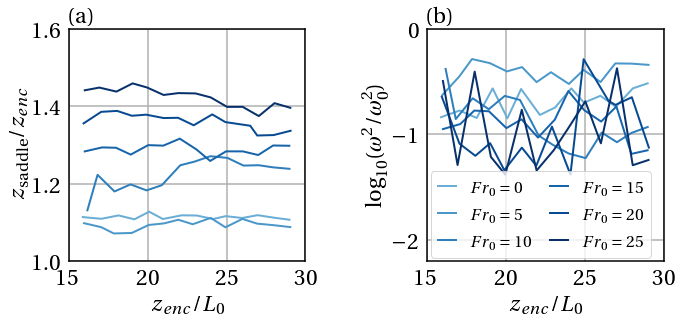

In [56]:
# Plot

blues = matplotlib.cm.get_cmap('Blues')
greens = matplotlib.cm.get_cmap('Greens')

f, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.grid(True,linewidth=1.5)
ax2.grid(True,linewidth=1.5)
ax1.tick_params(bottom=False,left=False)
ax2.tick_params(bottom=False,left=False)
ax1.set_ylim(1,1.6)
ax1.set_xlim(15,30)
ax2.set_ylim(-2.2,0)
ax2.set_xlim(15,30)
ax1.plot(S0.z_enc[1:-1]/L0,y_saddle_S0,c=blues(0.5))
ax1.plot(S05.z_enc[1:-1]/L0,y_saddle_S05,c=blues(0.6))
ax1.plot(S10.z_enc[1:-1]/L0,y_saddle_S10,c=blues(0.7))
ax1.plot(S15.z_enc[1:-1]/L0,y_saddle_S15,c=blues(0.8))
ax1.plot(time[1:-1],y_saddle_S20,c=blues(0.9))
ax1.plot(S25.z_enc[1:-1]/L0,y_saddle_S25,c=blues(1.0))
ax2.plot(S0.z_enc[1:-1]/L0,x_saddle_S0,c=blues(0.5),label=r'$Fr_0=0$')
ax2.plot(S05.z_enc[1:-1]/L0,x_saddle_S05,c=blues(0.6),label=r'$Fr_0=5$')
ax2.plot(S10.z_enc[1:-1]/L0,x_saddle_S10,c=blues(0.7),label=r'$Fr_0=10$')
ax2.plot(S15.z_enc[1:-1]/L0,x_saddle_S15,c=blues(0.8),label=r'$Fr_0=15$')
ax2.plot(time[1:-1],x_saddle_S20,c=blues(0.9),label=r'$Fr_0=20$')
ax2.plot(S25.z_enc[1:-1]/L0,x_saddle_S25,c=blues(1.0),label=r'$Fr_0=25$')
ax1.set_xlabel(r'$z_{enc}/L_0$')
ax2.set_xlabel(r'$z_{enc}/L_0$')
ax1.set_ylabel(r'$z_\mathrm{saddle}/z_{enc}$')
ax2.set_ylabel(r'$\mathrm{log}_{10}(\omega^2/\omega_0^2)$')
ax1.set_title('(a)',fontsize=24,loc='left')
ax2.set_title('(b)',fontsize=24,loc='left')
ax2.legend(loc='best',fontsize=18,handlelength=1,borderaxespad=0.2,ncol=2,columnspacing=1)
plt.tight_layout()
plt.savefig(opath+'pdfs_saddle_point_maxgrad_dy005_samplesizeylen.pdf',bbox_inches='tight')
plt.show()